# SVM Tutorial
### Alon Mann, Dean Shabi, Eden Agassi

### good sources:

https://www.datacamp.com/community/tutorials/support-vector-machines-r

https://www.svm-tutorial.com/2014/10/support-vector-regression-r

https://www.youtube.com/watch?v=9NrALgHFwTo


## Background - Maximal Margin Classifier

### Simulate separated data in 2D:

In [36]:
#Create sample data - Maximal Margin Classifier
set.seed(4)
options(warn=-1)

x1=c(rnorm(n = 21,mean = 1.5),rnorm(n = 21,mean = -1.5))
x2=c(rnorm(n = 21,mean = 1.5),rnorm(n = 21,mean = -1.5))
y=c(rep(1,21),rep(-1,21))

# x = matrix(x1,x2)
lin=data.frame(x1, x2 ,y)
lin$y=factor(lin$y)

### A simple logistic regression classifier

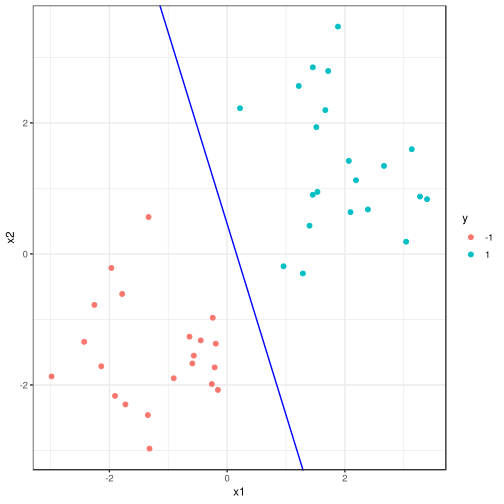

In [79]:
logit = glm(y~ ., data = lin, family = "binomial", maxit = 50)

slope <- coef(logit)[2]/(-coef(logit)[3])
intercept <- coef(logit)[1]/(-coef(logit)[3]) 

library(ggplot2)
ggplot(lin)+ geom_point(aes(x=x1,y=x2,color=y)) + theme_bw() + geom_abline(slope = slope, intercept = intercept, col="blue")

### SVM - Plotting the Hyperplane and the margins, notice the support vectors!

In [80]:
library('e1071')
svm.model <- svm(y ~ ., data=lin, kernel='linear',scale=FALSE)

w <- t(svm.model$coefs) %*% svm.model$SV
b <- -svm.model$rho
p <- svm.model$SV

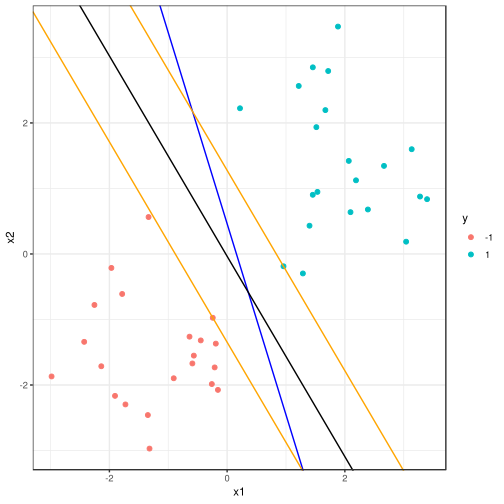

In [81]:
ggplot(lin)+ geom_point(aes(x=x1,y=x2,color=y)) + theme_bw() + geom_abline(slope = slope, intercept = intercept, col="blue") +
geom_abline(intercept = -b/w[1,2], slope = -w[1,1]/w[1,2], col="black") + geom_abline(intercept = (-b-1)/w[1,2], slope = -w[1,1]/w[1,2], col="orange") + geom_abline(intercept = (-b+1)/w[1,2], slope = -w[1,1]/w[1,2], col="orange")

### 3 ways to plot the SVM decision boundary

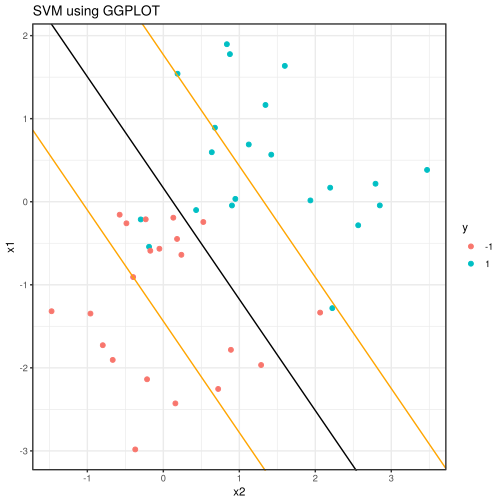

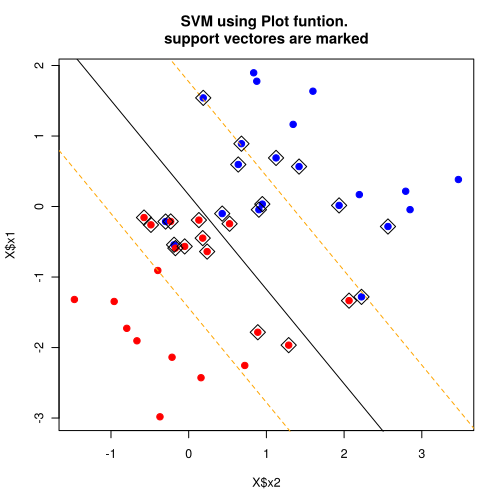

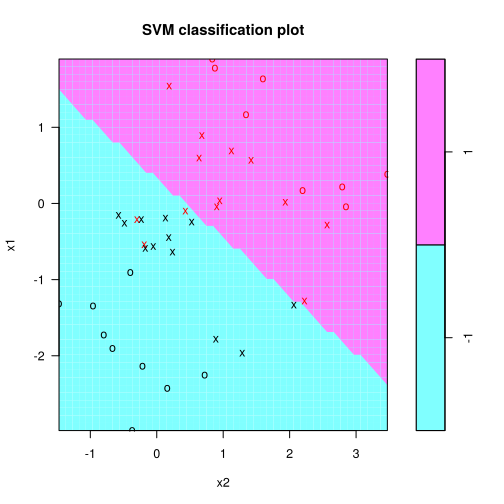

In [5]:
library(e1071)
library(dplyr)

svmfit2= svm(y~., data = lin2, kernel = "linear", cost = 1/10, scale = T)

w <- t(svmfit2$coefs) %*% svmfit2$SV
b <- -svmfit2$rho
p <- svmfit2$SV

#1 - ggplot
ggplot(lin2)+ ggtitle("SVM using GGPLOT") + geom_point(aes(x=x2,y=x1,color=y))+ theme_bw() + geom_abline(intercept = -b/w[1,2], slope = -w[1,1]/w[1,2], col="black") + 
geom_abline(intercept = (-b-1)/w[1,2], slope = -w[1,1]/w[1,2], col="orange") + geom_abline(intercept = (-b+1)/w[1,2], slope = -w[1,1]/w[1,2], col="orange")

#2 - Plot function
X = select(lin2, -y)
plot(X$x2, X$x1, col = y + 3, pch = 19)
abline(-b/w[1,2], -w[1,1]/w[1,2])
abline((-b-1)/w[1,2], -w[1,1]/w[1,2], lty = 2, col = "orange")
abline((-b+1)/w[1,2], -w[1,1]/w[1,2], lty = 2, col = "orange")

X = data.frame(X$x2, X$x1)
#Support vectors:
points(X[svmfit2$index,], pch = 5, cex = 2, title("SVM using Plot funtion. \nsupport vectores are marked"))


#3 - Ugly e1071 plot
plot(svmfit2, lin2)

# What if the data is not perfectly seperable?




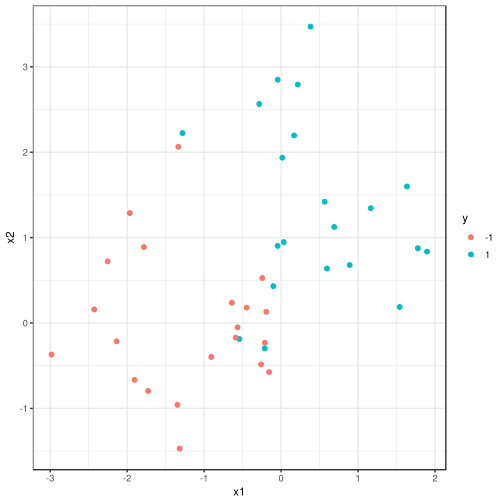

In [37]:
set.seed(4)
x1=c(rnorm(n = 21,mean = 0),rnorm(n = 21,mean = -1.5))
x2=c(rnorm(n = 21,mean = 1.5),rnorm(n = 21,mean = 0))
y=c(rep(1,21),rep(-1,21))

lin2=data.frame(x1, x2 ,y)
lin2$y=factor(lin2$y)

library(ggplot2)
ggplot(lin2)+ geom_point(aes(x=x1,y=x2,color=y)) + theme_bw()

### Adding a cost parameter - to allow some missclassifications.
what does it do? Helps us overcome overfit problems. The smaller the cost, the less we overfit.

There's a **balance** between the margin size and the cost size. A large cost function will cause a smaller margin.
You can think of the Cost as a **Budget** of errors the model is allowed to make.

The Constraint of SVM. The slack variable ξ able to states the "misclassification".

$$y_i(\mathbf{w}\cdot\mathbf{x_i} - b) \ge 1 - \xi_i \quad 1 \le i \le n. \quad\quad(1)$$

$$\arg\min_{\mathbf{w},\mathbf{\xi}, b } \left\{\frac{1}{2} \|\mathbf{w}\|^2 + C \sum_{i=1}^n \xi_i \right\} \quad\quad(2)$$

## Choosing the right cost parameter - using Cross-Validation with Caret package

In [38]:
library(boot)
library(caret)
set.seed(2112)
costGrid <- expand.grid(C = c(0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 5))

train_control = trainControl(method="repeatedcv", number=10, savePredictions = TRUE, repeats = 3) #10-fold CV
# model = train(y~., data=lin2, trControl=train_control,
#               method="svmLinear", tuneGrid = costGrid, tuneLength = 10)

svm.tune <- train(y~., data = lin2,
                    method = "svmLinear",
                    preProc = c("center","scale"),
                    tuneGrid = costGrid,
                    trControl=train_control)

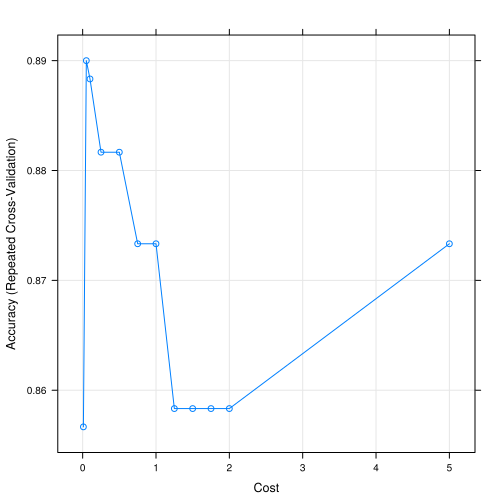

In [43]:
plot(svm.tune) #The final value used for the model was C = 0.05.

#svm.tune

### What if the data is not linearly separable?


a relatively simple solution would be to add features. however, this is costly. instead we can use the Kernel trick. we choose a kernel function and use it on our features. this function might turn our features into liniearly seperable.

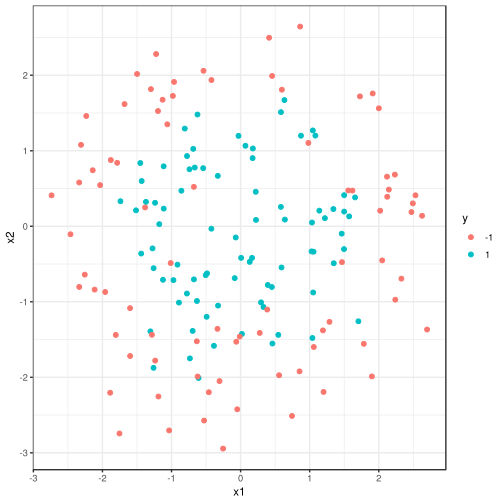

In [14]:
phi=runif(81)*2*pi
r1=1
r2=2
x1=c(r1*cos(phi),r2*cos(phi))
x2=c(r1*sin(phi),r2*sin(phi))
y=c(rep(1,81),rep(-1,81))

#Adding some noise, so the separation is not perfect
x1 = x1 + rnorm(n=81, sd = 0.5)
x2 = x2 + rnorm(n=81, sd = 0.5)
circ=data.frame(x1,x2,y)
circ$y=factor(circ$y)

library(ggplot2)
ggplot(circ)+ geom_point(aes(x=x1,y=x2,color=y)) + theme_bw()

 #### kernel functions. choose your kernel wisely

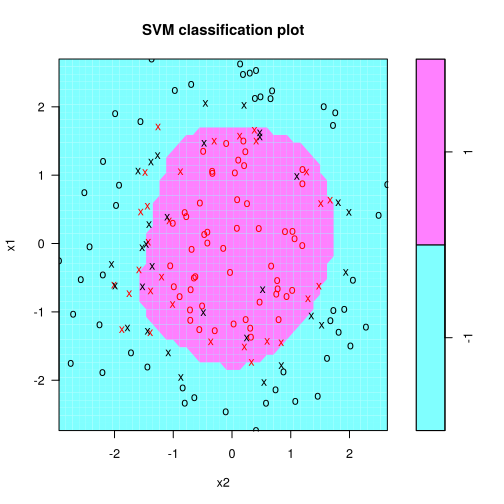

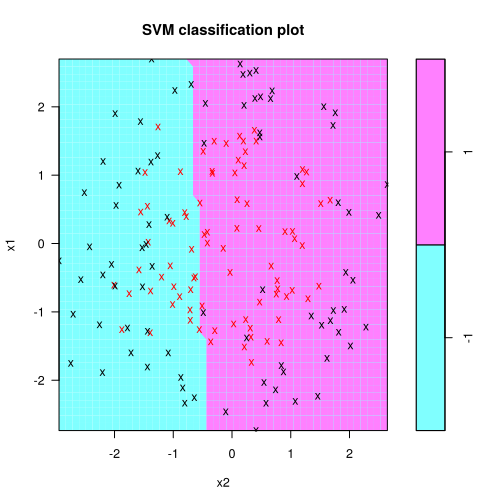

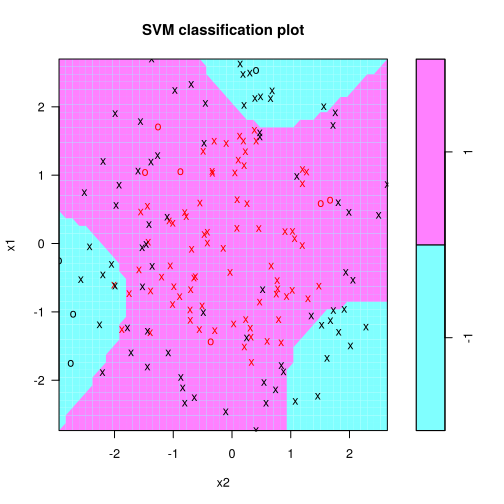

In [22]:
library(e1071)
svmfit_rbf= svm(y~., data = circ, kernel = "radial", cost = 10, scale = TRUE)
plot(svmfit_rbf, circ)

svmfit= svm(y~., data = circ, kernel = "linear", cost = 1/10, scale = FALSE)
plot(svmfit, circ)

svmfit= svm(y~., data = circ, kernel = "polynomial", cost = 1, scale = FALSE)
plot(svmfit, circ)



### Cross validation over multiple paremeters - Sigma and Cost on Radial Kernel

Loading required package: lattice


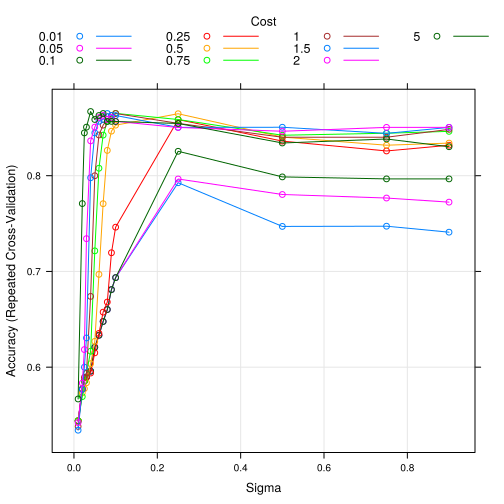

In [24]:
library(caret)
set.seed(2112)

train_control = trainControl(method="repeatedcv", number=10, savePredictions = TRUE, repeats = 3) #10-fold CV

grid_radial = expand.grid(sigma = c(0.01, 0.02, 0.025, 0.03, 0.04, 0.05, 0.06, 0.07,0.08, 0.09, 0.1, 0.25, 0.5, 0.75,0.9),
 C = c(0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1, 1.5, 2,5))
set.seed(3233)

#circular data
svm.tune.rbf = train(y~., data = circ,
                    method = "svmRadial",
                    preProc = c("center","scale"),
                    tuneGrid = grid_radial,
                    trControl=train_control,
                    tuneLength = 10)

#linear data
# svm.tune.rbf = train(y~., data = lin2,
#                     method = "svmRadial",
#                     preProc = c("center","scale"),
#                     tuneGrid = grid_radial,
#                     trControl=train_control,
#                     tuneLength = 10)
plot(svm.tune.rbf)

In [41]:
# svm.tune.rbf$resample  #<- Those are the folds and the accuracies
# getTrainPerf(svm.tune.rbf) #The best fold

In [42]:
## For the model associated with optimal Cp value, here is the predictions on the first hold-out subset.
# first_holdout = subset(svm.tune.rbf$pred, Resample == "Fold09.Rep3")
# postResample(first_holdout$pred, first_holdout$obs) #Accuracy for this subset

### SVR - Support Vector Regression.
we can also use SVM for regression problems. In this case, the MARGIN becomes a region where errors are allowd (no added loss if the SVR is "M" far from the real data), and the loss goes up as the model is mistaken.

![alt text](http://www.saedsayad.com/images/SVR_5.png "SVR")

https://medium.com/coinmonks/support-vector-regression-or-svr-8eb3acf6d0ff

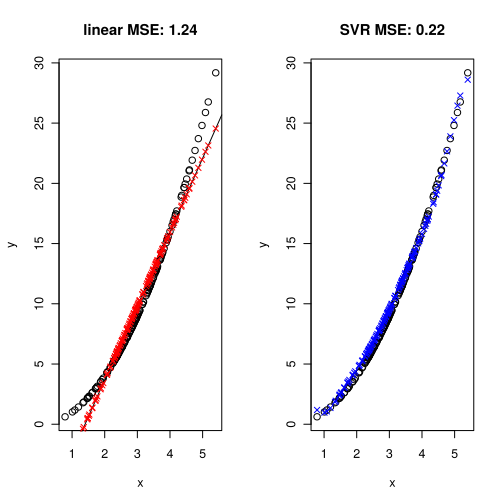

In [65]:
library(e1071)


# data making
set.seed(1)
x = rnorm(162, mean = 3)
y = x^2
plot(x, y)
reg = data.frame(x, y)

# regression models
lin_reg = lm(y ~ x, reg)
SVR = svm(y ~ x, kernel = "radial",cost=1000, data = reg)

# predections
yp_lin = predict(lin_reg, newdata = reg)
yp_svm = predict(SVR, newdata = reg)

# training error
MSE_lin = mean((yp_lin - y)^2)
MSE_SVR = mean((yp_svm - y)^2)

# graphix
par(mfrow = c(1, 2))

plot(x, y)
abline(lin_reg)
points(x, yp_lin, col = "red", pch = 4)
title(paste("linear MSE:", as.character(round(MSE_lin, 2))))

plot(x, y)
points(x, yp_svm, col = "blue", pch = 4)
title(paste("SVR MSE:", as.character(round(MSE_SVR, 2))))

# /

## Copy the following code to your own R studio for luxurious 3D interactive plots!

In [43]:
library(e1071)
library(rgl)
library(misc3d)

n    = 200
nnew = 50


# Simulate some data
set.seed(1)
group = sample(2, n, replace=T)
dat   = data.frame(group=factor(group), matrix(rnorm(n*3, rep(group, each=3)), ncol=3, byrow=T))

plotsvm = function(kernal, c){
  # Fit SVM
  fit = svm(group ~ ., kernel = kernal, cost = c, data=dat)

  # Plot original data
  plot3d(dat[,-1], col=dat$group, xlab = c)
  # Get decision values for a new data grid
  newdat.list = lapply(dat[,-1], function(x) seq(min(x), max(x), len=nnew))
  newdat      = expand.grid(newdat.list)
  newdat.pred = predict(fit, newdata=newdat, decision.values=T)
  newdat.dv   = attr(newdat.pred, 'decision.values')
  newdat.dv   = array(newdat.dv, dim=rep(nnew, 3))
  # Fit/plot an isosurface to the decision boundary
  contour3d(newdat.dv, level=0, x=newdat.list$X1, y=newdat.list$X2, z=newdat.list$X3, add=T, color = "cyan")
}

mfrow3d(nr = 1, nc = 2, sharedMouse = TRUE)
plotsvm("polynomial", c=4)
plotsvm("radial", c=4)

Warning message in rgl.init(initValue, onlyNULL):
“RGL: unable to open X11 display”

Warning message:
“'rgl_init' failed, running with rgl.useNULL = TRUE”